# 1. Data Set 설명

# 2. Data Preparation

In [1]:
# 라이브러리

from jbfg.pandas_utils import *
import calendar
from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np 
import pandas as pd
import pickle as pkl
import random
import IPython.display

#color = sns.color_palette("crest", 8)
#cmap_colors = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

#%matplotlib inline


#pd.options.mode.chained_assignment = None

In [1]:
from jbfg.pandas_utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pickle as pkl
import calendar

from datetime import date, datetime, timedelta
from dateutil.relativedelta import relativedelta

### 테이블 조회

In [172]:
schema = 'l2_kjbk_extnl'
products_sql = 'select * from products_info'
train_x_past_sql = 'select * from train_x_past'
train_x_current_sql = 'select * from train_x_current'
train_y_sql = 'select * from train_y'
test_x_past_sql = 'select * from test_x_past'
test_x_current_sql = 'select * from test_x_current'

In [173]:
products_info = get_df(products_sql, schema)
train_x_past = get_df(train_x_past_sql, schema)
train_x_current = get_df(train_x_current_sql, schema)
train_y = get_df(train_y_sql, schema)
test_x_past =(test_x_past_sql, schema)
test_x_current =(test_x_current_sql, schema)

In [174]:
products = products_info.copy()
train_past = train_x_past.copy()
train_current = train_x_current.copy()

AttributeError: 'tuple' object has no attribute 'copy'

In [317]:
# data 타입변환
def type_change(df, col, to_type):
    df[col] = df[col].astype(to_type)
    return df

def _str2int(strV, replaceV_when_blank):
    if strV in (None," ",""): return int(replaceV_when_blank)
    else: return int(float(strV.replace(" ","")))

In [318]:
type_change(train_past, ['order_number', 'week_day', 'order_hour', 'add_order', 'is_reordered'], 'int')
type_change(train_current, ['order_number', 'week_day', 'order_hour', 'add_order', 'is_reordered'], 'int')
train_past.order_interval = train_past.order_interval.map(lambda x : _str2int(x,0))
train_current.order_interval = train_current.order_interval.map(lambda x : _str2int(x,0))

### 테이블 합치기

In [233]:
# train_curr = train_current + train_y 
train_curr = pd.concat([train_current, train_y], axis=1) 
train_curr.head(3)


,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id
0,806422,41116,47,5,18,3,4,1,21709
1,2146033,127113,45,1,10,7,24,1,21709
2,3055498,140168,45,5,10,26,11,1,21709


In [234]:
# train = train_past + train_curr
train_past['last_order_yn'] = 0
train_curr['last_order_yn'] = 1

train = pd.concat([train_past,train_curr], axis=0)
display(train)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn
0,717029,196613,15,1,9,3,5,0,41220,0
1,2325772,196613,35,6,11,2,7,1,41220,0
2,642668,196613,69,2,16,2,11,1,4210,0
3,1326515,196613,61,3,19,3,3,1,4210,0
4,1437845,196613,36,3,15,4,16,0,4210,0
...,...,...,...,...,...,...,...,...,...,...
24419,3184000,174046,100,5,7,2,12,1,24852,1
24420,1754722,6710,100,5,11,3,21,1,24852,1
24421,1076973,150840,100,0,13,0,18,1,24852,1
24422,1247049,99707,100,1,13,3,6,1,24852,1


In [235]:
train = pd.merge(left = train, right = products, how = 'left', on = 'product_id')

In [301]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278396 entries, 0 to 1278395
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1278396 non-null  object
 1   cstno           1278396 non-null  object
 2   order_number    1278396 non-null  int64 
 3   week_day        1278396 non-null  int64 
 4   order_hour      1278396 non-null  int64 
 5   order_interval  1278396 non-null  int64 
 6   add_order       1278396 non-null  int64 
 7   is_reordered    1278396 non-null  int64 
 8   product_id      1278396 non-null  object
 9   last_order_yn   1278396 non-null  int64 
 10  name            1278396 non-null  object
 11  category_id     1278396 non-null  object
 12  division_id     1278396 non-null  object
 13  category_name   1278396 non-null  object
 14  division_name   1278396 non-null  object
dtypes: int64(7), object(8)
memory usage: 156.1+ MB


In [237]:
train_p = train.loc[train['last_order_yn'] ==0]
train_c = train.loc[train['last_order_yn'] ==1]

In [238]:
number_of_nulls = train['order_interval'].isnull().sum(axis=0)
print('total no. of values =', len(train))
print('no. of null values =', number_of_nulls)

total no. of values = 1278396
no. of null values = 0


In [239]:
train['last_order_yn'].value_counts()

0    1253972
1      24424
Name: last_order_yn, dtype: int64

In [17]:
train2.reset_index(drop=True, inplace=True)
train2.loc[0,:]

order_id          717029
cstno             196613
order_number          15
week_day               1
order_hour             9
order_interval         3
add_order              5
is_reordered           0
product_id         41220
last_order_yn          0
Name: 0, dtype: object

In [32]:
# row_number
def row_number(df, new_col, base_col, asc, agg_col):
    df[new_col] = df.sort_values(base_col, ascending=asc).groupby(agg_col).cumcount() +1
    return df

In [33]:
row_number(train2, 'add_order_2', 'add_order', True, ['cstno', 'order_number'])

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,week_day_nm,add_order_2
0,717029,196613,15,1,9,3.0,5,0,41220,0,1,1
1,2325772,196613,35,6,11,2.0,7,1,41220,0,6,2
2,642668,196613,69,2,16,2.0,11,1,4210,0,2,3
3,1326515,196613,61,3,19,3.0,3,1,4210,0,3,1
4,1437845,196613,36,3,15,4.0,16,0,4210,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1278391,3184000,174046,100,5,7,2.0,12,1,24852,1,5,5
1278392,1754722,6710,100,5,11,3.0,21,1,24852,1,5,6
1278393,1076973,150840,100,0,13,0.0,18,1,24852,1,0,9
1278394,1247049,99707,100,1,13,3.0,6,1,24852,1,1,2


In [34]:
train2.groupby('cstno')['order_number'].max() == train2.groupby('cstno')['order_number'].nunique()

cstno
10000     False
100001    False
100046    False
100071    False
100108    False
          ...  
9981      False
99829      True
99887     False
99894      True
99901     False
Name: order_number, Length: 5859, dtype: bool

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1278396 entries, 0 to 1278395
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   order_id        1278396 non-null  object 
 1   cstno           1278396 non-null  object 
 2   order_number    1278396 non-null  int64  
 3   week_day        1278396 non-null  object 
 4   order_hour      1278396 non-null  int64  
 5   order_interval  1256710 non-null  float64
 6   add_order       1278396 non-null  int64  
 7   is_reordered    1278396 non-null  object 
 8   product_id      1278396 non-null  object 
 9   last_order_yn   1278396 non-null  int64  
 10  name            1278396 non-null  object 
 11  category_id     1278396 non-null  object 
 12  division_id     1278396 non-null  object 
 13  category_name   1278396 non-null  object 
 14  division_name   1278396 non-null  object 
dtypes: float64(1), int64(4), object(10)
memory usage: 156.1+ MB


In [18]:
train.isnull().sum()

order_id              0
cstno                 0
order_number          0
week_day              0
order_hour            0
order_interval    21686
add_order             0
is_reordered          0
product_id            0
last_order_yn         0
name                  0
category_id           0
division_id           0
category_name         0
division_name         0
dtype: int64

In [ ]:
tmp_order_interval = train[['csto','cst_

In [17]:
type_change(train, ['order_interval'], 'int')

ValueError: Cannot convert non-finite values (NA or inf) to integer

In [15]:
train.shape

(1278396, 15)

In [57]:
train_p = train.loc[train['last_order_yn'] ==0]
train_c = train.loc[train['last_order_yn'] ==1]

In [58]:
train_p.head(3)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,name,category_id,division_id,category_name,division_name
0,717029,196613,15,1,9,3.0,5,0,41220,0,Organic Romaine Lettuce,83,4,fresh vegetables,produce
1,2325772,196613,35,6,11,2.0,7,1,41220,0,Organic Romaine Lettuce,83,4,fresh vegetables,produce
2,642668,196613,69,2,16,2.0,11,1,4210,0,Whole Milk,84,16,milk,dairy eggs


# 3. EDA 및 데이터 전처리

In [184]:
# 상품수
print("Unique products : {}".format(len(products.product_id.unique())))

Unique products : 100


In [185]:
# train 고객수
print("Unique cstnos : {}".format(len(train.cstno.unique())))

Unique cstnos : 5859


In [186]:
print(train.shape)

(1278396, 15)


>요일과 시간에 따른 구매 패턴 확인

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


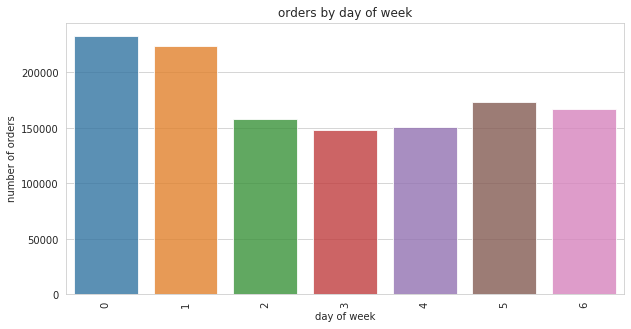

In [187]:
# 요일별 주문수 (0: 일요일, --- , 6:토요일) -> 주문이 발생한 요일은 0~6으로 구분
orders_by_dayofweek= train_p.groupby('week_day')['order_id'].count()
#print(orders_by_dayofweek.head(10))
plt.figure(figsize=(10,5))
sns.barplot(orders_by_dayofweek.index, orders_by_dayofweek.values, alpha=0.8)
plt.xlabel('day of week')
plt.ylabel('number of orders')
plt.title('orders by day of week')
plt.xticks(rotation='vertical')
plt.show()


/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


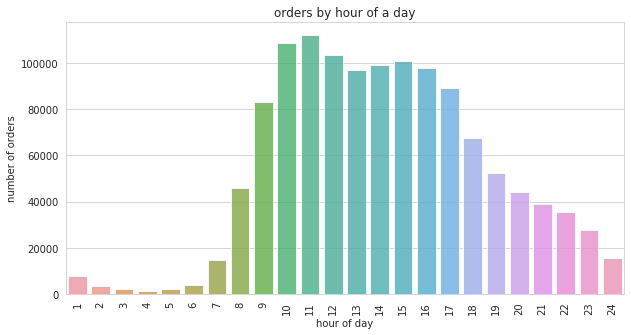

In [188]:
# 시간별 주문수
orders_by_hour= train_p.groupby('order_hour')['order_id'].count()
#print(orders_by_hour.head(24))
plt.figure(figsize=(10,5))
sns.barplot(orders_by_hour.index +1, orders_by_hour.values, alpha=0.8)
plt.xlabel('hour of day')
plt.ylabel('number of orders')
plt.title('orders by hour of a day')
plt.xticks(rotation='vertical')
plt.show()


In [189]:
#구매요일 구매시간 주문번호
orders_by_hourAndDay= train_p.groupby(['week_day','order_hour'])['order_id'].count().reset_index()
orders_by_hourAndDay.head()
#df_importance.rename(columns={:'importance_score_sum'},inplace=True)

,week_day,order_hour,order_id
0,0,0,1459
1,0,1,779
2,0,2,362
3,0,3,307
4,0,4,352


   week_day  order_hour  order_count day_and_hour
0         0           0         1459          0_0
1         0           1          779          0_1
2         0           2          362          0_2
3         0           3          307          0_3
4         0           4          352          0_4
5         0           5          486          0_5
6         0           6         1709          0_6
7         0           7         7015          0_7
8         0           8        14593          0_8
9         0           9        19222          0_9


/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


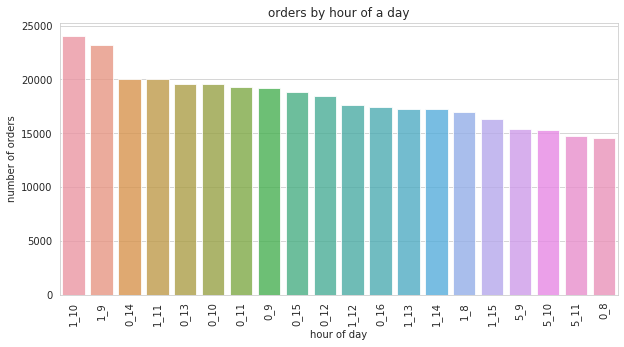

In [190]:
# day_and_hour 컬럼 추가
orders_by_hourAndDay.rename(columns={'order_id':'order_count'},inplace=True)
orders_by_hourAndDay['day_and_hour']= orders_by_hourAndDay['week_day'].astype(str)+'_'+orders_by_hourAndDay['order_hour'].astype(str)
print(orders_by_hourAndDay.head(10))
plt.figure(figsize=(10,5))
orders_by_hourAndDay.sort_values('order_count', ascending=False, inplace=True)
sns.barplot(orders_by_hourAndDay['day_and_hour'][:20],orders_by_hourAndDay['order_count'][:20], order=orders_by_hourAndDay['day_and_hour'][:20], alpha=0.8)
plt.xlabel('hour of day')
plt.ylabel('number of orders')
plt.title('orders by hour of a day')
plt.xticks(rotation='vertical')
plt.show()

>직전 구매 후 경과일수에 따른 구매 패턴 확인

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


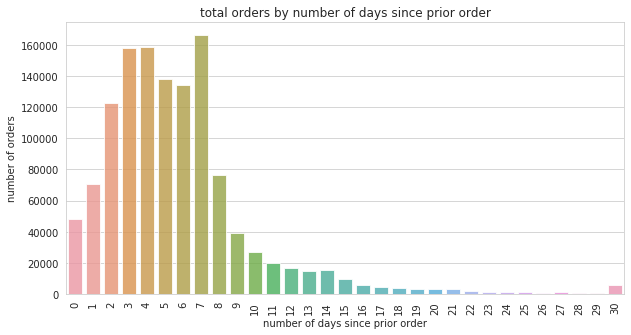

In [191]:
# 직전 구매 후 경과일수 분석
orders_cleaned= train_p[train_p['order_interval'].notnull()]
len(orders_cleaned)

orders_by_days_prior_order= train_p.groupby('order_interval')['order_id'].count()
plt.figure(figsize=(10,5))
sns.barplot(orders_by_days_prior_order.index, orders_by_days_prior_order.values, alpha=0.8)
plt.xlabel('number of days since prior order')
plt.ylabel('number of orders')
plt.title('total orders by number of days since prior order')
plt.xticks(rotation='vertical')
plt.show()

In [192]:
#No. of products per order
products_per_order= train_p.groupby('order_id')['add_order'].max().reset_index()
products_per_order= products_per_order['add_order'].value_counts()
products_per_order_100= products_per_order.sort_values(ascending=False)[:100]
print(products_per_order_100.head(100))
print("")
print('Median no. of products in an order is ', train_p.groupby('order_id')['add_order'].max().median())

4      26189
5      25566
3      25235
6      24728
7      22960
       ...  
66         1
92         1
110        1
96         1
115        1
Name: add_order, Length: 85, dtype: int64

Median no. of products in an order is  8.0


>상품별 판매 패턴 확인

In [193]:
# train_p copy
orders_with_order_products= train_p.copy()

#  check for null or duplicate values.
with open('orders_with_order_products.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

with open('orders_with_order_products.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [194]:
orders_with_order_products.isnull().any()    

order_id          False
cstno             False
order_number      False
week_day          False
order_hour        False
order_interval    False
add_order         False
is_reordered      False
product_id        False
last_order_yn     False
name              False
category_id       False
division_id       False
category_name     False
division_name     False
dtype: bool

In [195]:
orders_with_order_products.duplicated().any()

False

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


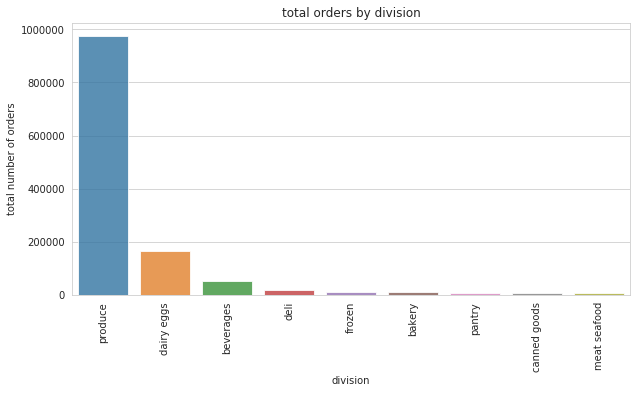

In [196]:
#상품 대분류별 판매현황
division_wise_orders= orders_with_order_products['division_name'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(division_wise_orders.index, division_wise_orders.values, alpha=0.8)
plt.xlabel('division')
plt.ylabel('total number of orders')
plt.title('total orders by division')
plt.xticks(rotation='vertical')
plt.show()


/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


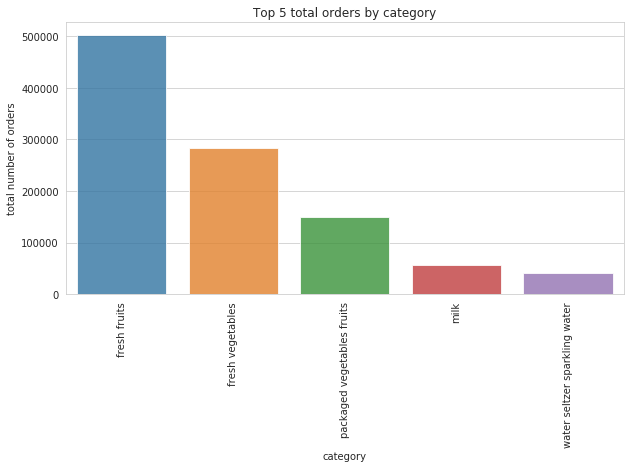

In [197]:
#상품 카테고리별 판매현황
category_wise_orders= orders_with_order_products['category_name'].value_counts()[:5]
plt.figure(figsize=(10,5))
sns.barplot(category_wise_orders.index, category_wise_orders.values, alpha=0.8)
plt.xlabel('category')
plt.ylabel('total number of orders')
plt.title('Top 5 total orders by category')
plt.xticks(rotation='vertical')
plt.show()

Banana                                  74686
Bag of Organic Bananas                  67514
Organic Strawberries                    52917
Organic Hass Avocado                    42604
Organic Baby Spinach                    40112
Organic Whole Milk                      29757
Organic Raspberries                     28207
Organic Avocado                         25046
Limes                                   21216
Large Lemon                             21012
Organic Yellow Onion                    20977
Organic Garlic                          19332
Apple Honeycrisp Organic                18511
Strawberries                            17900
Organic Zucchini                        17884
Organic Large Extra Fancy Fuji Apple    16387
Organic Lemon                           15970
Organic Gala Apples                     15611
Organic Cucumber                        15470
Organic Blueberries                     14859
Name: name, dtype: int64


/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


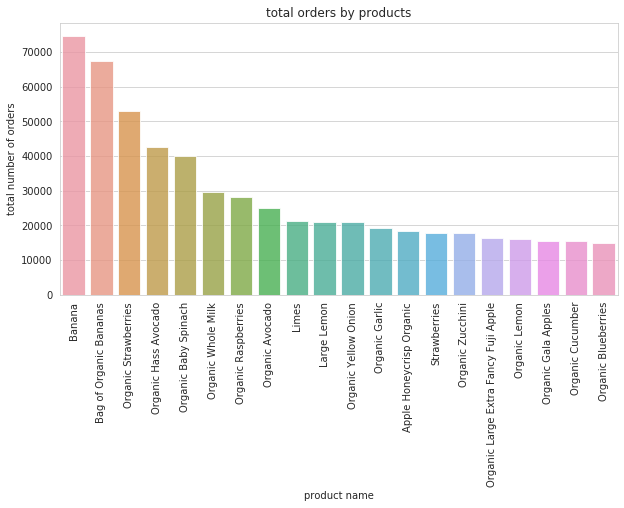

In [198]:
#가장 많이 구매한 상품 top20
products_wise_order= orders_with_order_products['name'].value_counts()
products_wise_order= products_wise_order[:20]
print(products_wise_order)
plt.figure(figsize=(10,5))
sns.barplot(products_wise_order.index, products_wise_order.values, alpha=0.8)
plt.xlabel('product name')
plt.ylabel('total number of orders')
plt.title('total orders by products')
plt.xticks(rotation='vertical')
plt.show()

In [199]:
orders_with_order_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1253972 entries, 0 to 1253971
Data columns (total 15 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   order_id        1253972 non-null  object
 1   cstno           1253972 non-null  object
 2   order_number    1253972 non-null  int64 
 3   week_day        1253972 non-null  int64 
 4   order_hour      1253972 non-null  int64 
 5   order_interval  1253972 non-null  int64 
 6   add_order       1253972 non-null  int64 
 7   is_reordered    1253972 non-null  int64 
 8   product_id      1253972 non-null  object
 9   last_order_yn   1253972 non-null  int64 
 10  name            1253972 non-null  object
 11  category_id     1253972 non-null  object
 12  division_id     1253972 non-null  object
 13  category_name   1253972 non-null  object
 14  division_name   1253972 non-null  object
dtypes: int64(7), object(8)
memory usage: 153.1+ MB


>재구매 패턴 확인

In [240]:
with open('orders_with_order_products.pkl', 'rb') as f:
    orders_with_order_products = pkl.load(f)

In [241]:
#고객별 재구매수
reorders_cstno= orders_with_order_products.groupby('cstno')['is_reordered'].sum().reset_index()
reorders_cstno.head()

,cstno,is_reordered
0,10000,300
1,100001,304
2,100046,200
3,100071,193
4,100108,151


In [242]:
# 고객별 재구매수 top20
reorders_cstno= reorders_cstno.sort_values(by=['is_reordered'], ascending=False)[:20]
reorders_cstno.head(20)

,cstno,is_reordered
1611,150840,745
117,103593,743
2669,184451,718
5728,95967,709
30,100787,702
4426,54485,696
2300,172806,686
2367,175294,684
521,115495,680
1905,160106,678


/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


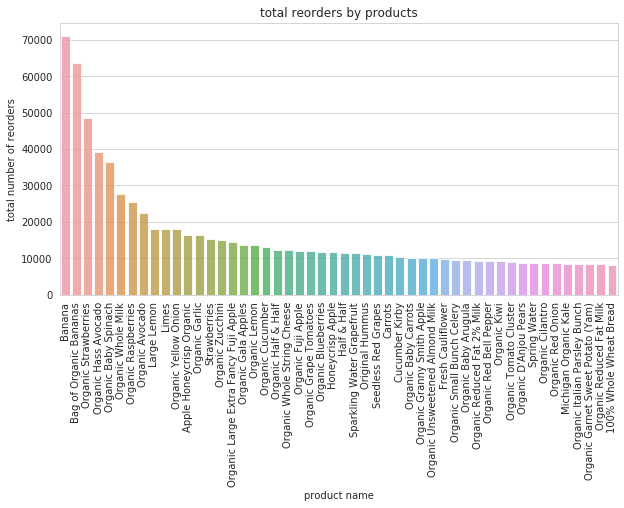

In [243]:
# 상품별 재구매

reorders_products= orders_with_order_products.groupby('name')['is_reordered'].sum().reset_index()
reorders_products.head()

reorders_products= reorders_products.sort_values(by=['is_reordered'], ascending=False)[:50]
plt.figure(figsize=(10,5))
sns.barplot(reorders_products['name'], reorders_products['is_reordered'], alpha=0.8)
plt.xlabel('product name')
plt.ylabel('total number of reorders')
plt.title('total reorders by products')
plt.xticks(rotation='vertical')
plt.show()


/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


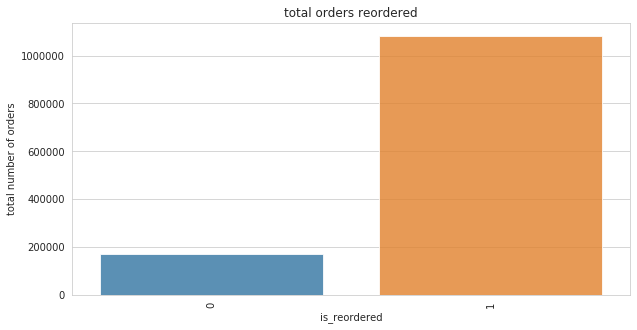

Total no. of 1st time order = 170198
Total no. of reorders = 1083774


In [244]:
#전체주문에서 재주문비율 (첫주문 : 0, 재주문: 1)
reorders= orders_with_order_products['is_reordered'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(reorders.index, reorders.values, alpha=0.8)
plt.xlabel('is_reordered')
plt.ylabel('total number of orders')
plt.title('total orders reordered')
plt.xticks(rotation='vertical')
plt.show()

print('Total no. of 1st time order =', reorders[0])
print('Total no. of reorders =', reorders[1])

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


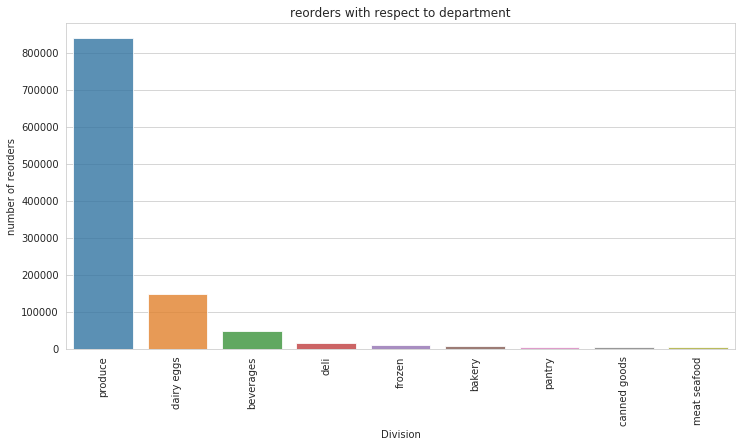

In [245]:
#상품 대분류별 재주문
reorders_department_average= orders_with_order_products.groupby('division_name')['is_reordered'].sum()
reorders_department_average= reorders_department_average.sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(reorders_department_average.index, reorders_department_average.values, alpha=0.8)
plt.xlabel('Division')
plt.ylabel('number of reorders')
plt.title('reorders with respect to department')
plt.xticks(rotation='vertical')
plt.show()

> add new features

In [246]:
# Number of orders for each user  고객별 주문수
# https://www.geeksforgeeks.org/get-unique-values-from-a-column-in-pandas-dataframe/
number_of_orders = orders_with_order_products.groupby('cstno')['order_id'].nunique().reset_index()
number_of_orders.rename(columns={'order_id':'num_orders'},inplace=True)
number_of_orders.head()
# percentage 

,cstno,num_orders
0,10000,66
1,100001,63
2,100046,62
3,100071,51
4,100108,63


In [247]:
orders_with_order_products= pd.merge(orders_with_order_products, number_of_orders, on='cstno', how='left')
del number_of_orders

In [248]:
order_length = orders_with_order_products.groupby('order_id').size().reset_index()
order_length.rename(columns={0:'order_length'},inplace=True)
order_length.head()

,order_id,order_length
0,1000003,13
1,1000015,5
2,1000019,1
3,1000026,1
4,1000027,2


In [249]:
orders_with_order_products= pd.merge(orders_with_order_products, order_length, on='order_id', how='left')
del order_length

In [250]:
# order importance = order_number/num_orders
# More recent orders have more weight
orders_with_order_products['order_importance'] = orders_with_order_products['order_number']/orders_with_order_products['num_orders']

In [251]:
# product importance = (order_length-add_to_cart_order+1)/order_length
# Assign more importance to products that are added earlier to the cart for each order
orders_with_order_products['product_importance'] = (orders_with_order_products['order_length']-orders_with_order_products['add_order']+1)/orders_with_order_products['order_length']

In [252]:
# importance_score = product_importance * order_importance
# for each product-order pair
orders_with_order_products['importance_score'] = orders_with_order_products['product_importance']*orders_with_order_products['order_importance']
orders_with_order_products.tail(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,name,category_id,division_id,category_name,division_name,num_orders,order_length,order_importance,product_importance,importance_score
1253962,1449524,163819,46,1,16,7,3,1,24852,0,Banana,24,4,fresh fruits,produce,47,8,0.978723,0.750000,0.734043
1253963,1471330,163819,7,1,10,12,1,1,24852,0,Banana,24,4,fresh fruits,produce,47,4,0.148936,1.000000,0.148936
1253964,1518830,163819,2,2,11,7,5,1,24852,0,Banana,24,4,fresh fruits,produce,47,4,0.042553,0.000000,0.000000
1253965,1714563,163819,3,1,16,13,1,1,24852,0,Banana,24,4,fresh fruits,produce,47,5,0.063830,1.000000,0.063830
1253966,1727821,163819,38,1,11,7,14,1,24852,0,Banana,24,4,fresh fruits,produce,47,4,0.808511,-2.250000,-1.819149
1253967,1902783,163819,47,0,19,13,2,1,24852,0,Banana,24,4,fresh fruits,produce,47,8,1.000000,0.875000,0.875000
1253968,1969590,163819,42,1,15,6,3,1,24852,0,Banana,24,4,fresh fruits,produce,47,4,0.893617,0.500000,0.446809
1253969,2549215,163819,9,1,11,7,1,1,24852,0,Banana,24,4,fresh fruits,produce,47,5,0.191489,1.000000,0.191489
1253970,3103211,163819,39,1,14,7,3,1,24852,0,Banana,24,4,fresh fruits,produce,47,3,0.829787,0.333333,0.276596
1253971,3207262,163819,8,1,12,7,1,1,24852,0,Banana,24,4,fresh fruits,produce,47,2,0.170213,1.000000,0.170213


In [253]:
with open('orders_with_order_products_new10.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [254]:
with open('orders_with_order_products_new10.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [255]:
with open('orders_with_order_products_new1.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [256]:
with open('orders_with_order_products_new1.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [257]:
# sum up the importance_scores for each product_id for each cstno
# This feature will be most important feature as it gives a sum of all importance score based on a customer and product unique combination. 
df_importance = orders_with_order_products.groupby(['cstno','product_id'])['importance_score'].sum().reset_index()
df_importance.rename(columns={'importance_score':'importance_score_sum'},inplace=True)
df_importance.head(10)

,cstno,product_id,importance_score_sum
0,10000,10749,-0.320780
1,10000,11520,-4.170996
2,10000,13176,-4.538717
3,10000,15290,0.567280
4,10000,16759,-0.471380
5,10000,17794,-3.501299
6,10000,18465,0.036364
7,10000,19660,0.037879
8,10000,21137,-6.208675
9,10000,21903,-3.872006


In [258]:
orders_with_order_products= pd.merge(orders_with_order_products,df_importance, on=['cstno','product_id'],how='left')
 
orders_with_order_products.head(10)

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,...,category_id,division_id,category_name,division_name,num_orders,order_length,order_importance,product_importance,importance_score,importance_score_sum
0,717029,196613,15,1,9,3,5,0,41220,0,...,83,4,fresh vegetables,produce,70,2,0.214286,-1.0,-0.214286,-0.714286
1,2325772,196613,35,6,11,2,7,1,41220,0,...,83,4,fresh vegetables,produce,70,3,0.500000,-1.0,-0.500000,-0.714286
2,642668,196613,69,2,16,2,11,1,4210,0,...,84,16,milk,dairy eggs,70,5,0.985714,-1.0,-0.985714,-3.042857
3,1326515,196613,61,3,19,3,3,1,4210,0,...,84,16,milk,dairy eggs,70,2,0.871429,0.0,0.000000,-3.042857
4,1437845,196613,36,3,15,4,16,0,4210,0,...,84,16,milk,dairy eggs,70,3,0.514286,-4.0,-2.057143,-3.042857
5,185079,196613,94,6,17,6,1,1,38689,0,...,84,16,milk,dairy eggs,70,3,1.342857,1.0,1.342857,-7.666905
6,358293,196613,93,0,11,4,1,1,38689,0,...,84,16,milk,dairy eggs,70,2,1.328571,1.0,1.328571,-7.666905
7,539821,196613,50,6,15,4,13,1,38689,0,...,84,16,milk,dairy eggs,70,4,0.714286,-2.0,-1.428571,-7.666905
8,642668,196613,69,2,16,2,15,1,38689,0,...,84,16,milk,dairy eggs,70,5,0.985714,-1.8,-1.774286,-7.666905
9,696513,196613,66,3,21,0,2,1,38689,0,...,84,16,milk,dairy eggs,70,1,0.942857,0.0,0.000000,-7.666905


In [259]:
with open('orders_with_order_products_new11.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [260]:
with open('orders_with_order_products_new11.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [261]:
with open('orders_with_order_products_new2.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [262]:
with open('orders_with_order_products_new2.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [263]:
#number of reorders of a customer
reorders_cstno = orders_with_order_products.groupby('cstno')['is_reordered'].sum().reset_index()
reorders_cstno.head()
reorders_cstno.columns= ['cstno', 'reordered_count']

In [292]:
# dropping columns
orders_with_order_products= orders_with_order_products.drop(['division_name', 'category_name', 'last_order_yn','name'], axis=1)
import gc
gc.collect()

0

In [293]:
import gc
orders_with_order_products= pd.merge(orders_with_order_products, reorders_cstno, on='cstno', how='left')
del reorders_cstno
gc.collect()

NameError: name 'reorders_cstno' is not defined

In [265]:
# 고객의 재주문율 -> add feature
reorders_cstno_average = orders_with_order_products.groupby('cstno')['is_reordered'].mean().reset_index()
reorders_cstno_average.rename(columns={'is_reordered':'reorder_ratio'},inplace=True)

reorders_cstno_average.head()

,cstno,reorder_ratio
0,10000,0.872093
1,100001,0.883721
2,100046,0.858369
3,100071,0.877273
4,100108,0.872832


In [266]:
orders_with_order_products= pd.merge(orders_with_order_products, reorders_cstno_average, on='cstno', how='left')
del reorders_cstno_average
gc.collect()

0

In [267]:
orders_with_order_products.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,...,category_name,division_name,num_orders,order_length,order_importance,product_importance,importance_score,importance_score_sum,reordered_count,reorder_ratio
0,717029,196613,15,1,9,3,5,0,41220,0,...,fresh vegetables,produce,70,2,0.214286,-1.0,-0.214286,-0.714286,161,0.793103
1,2325772,196613,35,6,11,2,7,1,41220,0,...,fresh vegetables,produce,70,3,0.500000,-1.0,-0.500000,-0.714286,161,0.793103
2,642668,196613,69,2,16,2,11,1,4210,0,...,milk,dairy eggs,70,5,0.985714,-1.0,-0.985714,-3.042857,161,0.793103
3,1326515,196613,61,3,19,3,3,1,4210,0,...,milk,dairy eggs,70,2,0.871429,0.0,0.000000,-3.042857,161,0.793103
4,1437845,196613,36,3,15,4,16,0,4210,0,...,milk,dairy eggs,70,3,0.514286,-4.0,-2.057143,-3.042857,161,0.793103


In [268]:
with open('orders_with_order_products_new4.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [269]:
with open('orders_with_order_products_new4.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [270]:
orders_with_order_products.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,...,category_name,division_name,num_orders,order_length,order_importance,product_importance,importance_score,importance_score_sum,reordered_count,reorder_ratio
0,717029,196613,15,1,9,3,5,0,41220,0,...,fresh vegetables,produce,70,2,0.214286,-1.0,-0.214286,-0.714286,161,0.793103
1,2325772,196613,35,6,11,2,7,1,41220,0,...,fresh vegetables,produce,70,3,0.500000,-1.0,-0.500000,-0.714286,161,0.793103
2,642668,196613,69,2,16,2,11,1,4210,0,...,milk,dairy eggs,70,5,0.985714,-1.0,-0.985714,-3.042857,161,0.793103
3,1326515,196613,61,3,19,3,3,1,4210,0,...,milk,dairy eggs,70,2,0.871429,0.0,0.000000,-3.042857,161,0.793103
4,1437845,196613,36,3,15,4,16,0,4210,0,...,milk,dairy eggs,70,3,0.514286,-4.0,-2.057143,-3.042857,161,0.793103


In [231]:
#droppint is_reordered
Y= orders_with_order_products['is_reordered']
orders_with_order_products= orders_with_order_products.drop('is_reordered', axis=1)

In [271]:
with open('X.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)
with open('Y.pkl', 'wb') as f:
    pkl.dump(Y,f)

In [272]:
with open('X.pkl', 'rb') as f:
    X= pkl.load(f)
with open('Y.pkl', 'rb') as f:
    Y= pkl.load(f)

>Univariate analysis

In [273]:
orders_with_order_products.head()

,order_id,cstno,order_number,week_day,order_hour,order_interval,add_order,is_reordered,product_id,last_order_yn,...,category_name,division_name,num_orders,order_length,order_importance,product_importance,importance_score,importance_score_sum,reordered_count,reorder_ratio
0,717029,196613,15,1,9,3,5,0,41220,0,...,fresh vegetables,produce,70,2,0.214286,-1.0,-0.214286,-0.714286,161,0.793103
1,2325772,196613,35,6,11,2,7,1,41220,0,...,fresh vegetables,produce,70,3,0.500000,-1.0,-0.500000,-0.714286,161,0.793103
2,642668,196613,69,2,16,2,11,1,4210,0,...,milk,dairy eggs,70,5,0.985714,-1.0,-0.985714,-3.042857,161,0.793103
3,1326515,196613,61,3,19,3,3,1,4210,0,...,milk,dairy eggs,70,2,0.871429,0.0,0.000000,-3.042857,161,0.793103
4,1437845,196613,36,3,15,4,16,0,4210,0,...,milk,dairy eggs,70,3,0.514286,-4.0,-2.057143,-3.042857,161,0.793103


/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplot

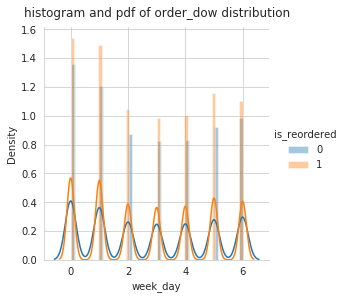

In [274]:
# 구매요일
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products, hue="is_reordered", height=4).map(sns.distplot,"week_day").add_legend()
plt.title('histogram and pdf of order_dow distribution', pad=10)
plt.show()

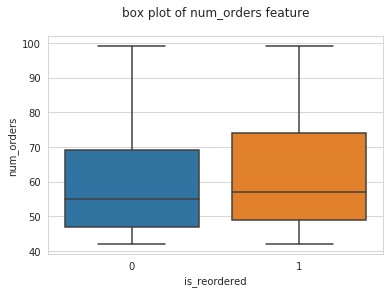

In [156]:
sns.boxplot(x='is_reordered',y='num_orders',data= orders_with_order_products) 
plt.title('box plot of num_orders feature',pad=20)
plt.show()

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplot

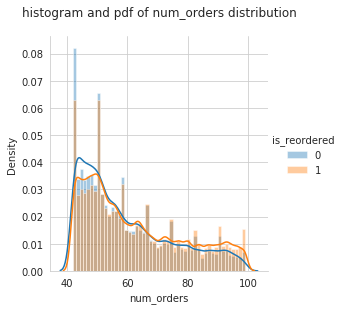

In [153]:
#num_orders
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="is_reordered",height=4).map(sns.distplot,"num_orders").add_legend()
plt.title('histogram and pdf of num_orders distribution',pad=20)
plt.show()

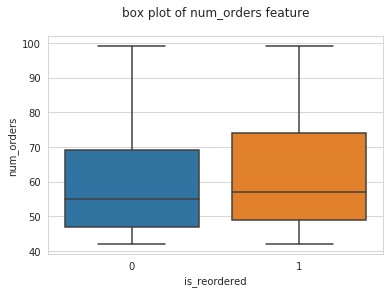

In [155]:
sns.boxplot(x='is_reordered',y='num_orders',data= orders_with_order_products) 
plt.title('box plot of num_orders feature',pad=20)
plt.show()

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplot

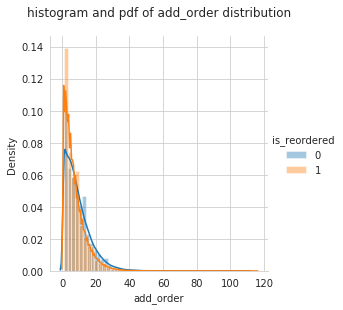

In [162]:
#add_order(cart)
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="is_reordered",height=4).map(sns.distplot,"add_order").add_legend()
plt.title('histogram and pdf of add_order distribution',pad=20)
plt.show()

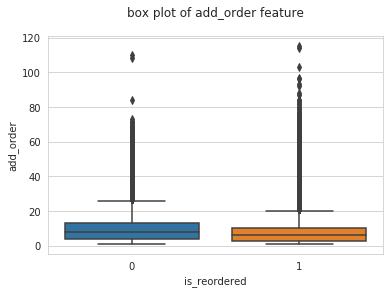

In [163]:
# Remove outliers i.e above 90th perecntile.
sns.boxplot(x='is_reordered',y='add_order',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of add_order feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

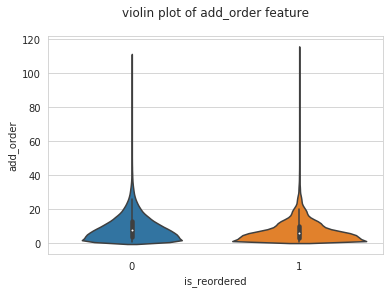

In [164]:
sns.violinplot(x="is_reordered",y="add_order",data=orders_with_order_products)
plt.title('violin plot of add_order feature',pad=20)
plt.show()

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplot

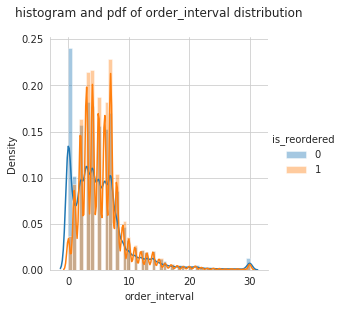

In [167]:
#order_interval
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="is_reordered",height=4).map(sns.distplot,"order_interval").add_legend()
plt.title('histogram and pdf of order_interval distribution',pad=20)
plt.show()

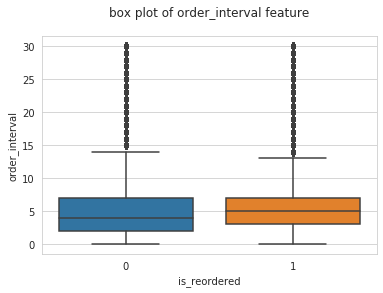

In [168]:
sns.boxplot(x='is_reordered',y='order_interval',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of order_interval feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

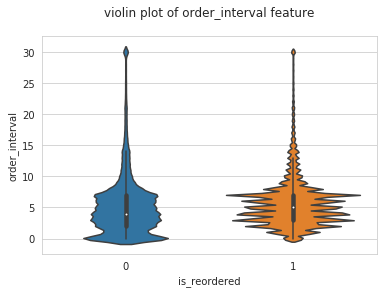

In [169]:
sns.violinplot(x="is_reordered",y="order_interval",data=orders_with_order_products)
plt.title('violin plot of order_interval feature',pad=20)
plt.show()

/opt/conda/envs/python3.6/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/conda/envs/python3.6/lib/python3.6/site-packages/matplot

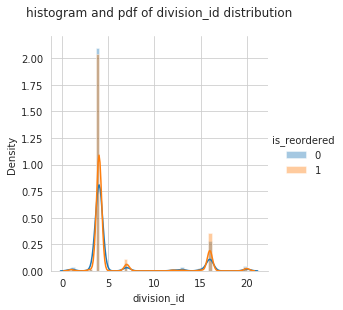

In [278]:
#division_id (대분류)
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="is_reordered",height=4).map(sns.distplot,"division_id").add_legend()
plt.title('histogram and pdf of division_id distribution',pad=20)
plt.show()

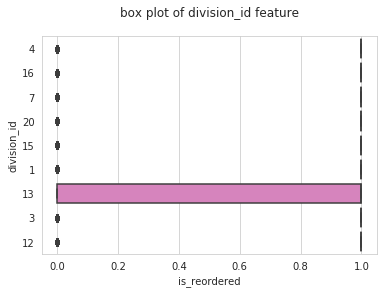

In [279]:
sns.boxplot(x='is_reordered',y='division_id',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of division_id feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

# 4. 모델링 및 결과

In [280]:
with open('X.pkl', 'rb') as f:
    X= pkl.load(f)
with open('Y.pkl', 'rb') as f:
    Y= pkl.load(f)

In [281]:
X.shape

(1253972, 23)

In [283]:
# removing useless features. We need only user related with each product for each order.
orders_with_order_products = orders_with_order_products.drop(['order_interval', 'order_id','order_number', 'week_day', 'order_hour',
                                                             'add_order', 'category_id', 'order_importance',
                                                             'product_importance', 'importance_score', 'is_reordered'], axis=1) 
orders_with_order_products.head()

,cstno,product_id,last_order_yn,name,division_id,category_name,division_name,num_orders,order_length,importance_score_sum,reordered_count,reorder_ratio
0,196613,41220,0,Organic Romaine Lettuce,4,fresh vegetables,produce,70,2,-0.714286,161,0.793103
1,196613,41220,0,Organic Romaine Lettuce,4,fresh vegetables,produce,70,3,-0.714286,161,0.793103
2,196613,4210,0,Whole Milk,16,milk,dairy eggs,70,5,-3.042857,161,0.793103
3,196613,4210,0,Whole Milk,16,milk,dairy eggs,70,2,-3.042857,161,0.793103
4,196613,4210,0,Whole Milk,16,milk,dairy eggs,70,3,-3.042857,161,0.793103


In [284]:
mean_order_len_user = orders_with_order_products.groupby('cstno')['order_length'].mean().reset_index()
mean_order_len_user.rename(columns={'order_length':'mean_order_length_user'},inplace=True)
mean_order_len_user.head()

,cstno,mean_order_length_user
0,10000,6.610465
1,100001,6.784884
2,100046,4.931330
3,100071,5.554545
4,100108,3.751445


In [285]:
orders_with_order_products= orders_with_order_products.merge(mean_order_len_user, on='cstno', how='left')
orders_with_order_products.head()

,cstno,product_id,last_order_yn,name,division_id,category_name,division_name,num_orders,order_length,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
0,196613,41220,0,Organic Romaine Lettuce,4,fresh vegetables,produce,70,2,-0.714286,161,0.793103,3.699507
1,196613,41220,0,Organic Romaine Lettuce,4,fresh vegetables,produce,70,3,-0.714286,161,0.793103,3.699507
2,196613,4210,0,Whole Milk,16,milk,dairy eggs,70,5,-3.042857,161,0.793103,3.699507
3,196613,4210,0,Whole Milk,16,milk,dairy eggs,70,2,-3.042857,161,0.793103,3.699507
4,196613,4210,0,Whole Milk,16,milk,dairy eggs,70,3,-3.042857,161,0.793103,3.699507


In [286]:
orders_with_order_products= orders_with_order_products.drop(['order_length'], axis=1)
orders_with_order_products= orders_with_order_products.drop_duplicates()
orders_with_order_products.head()

,cstno,product_id,last_order_yn,name,division_id,category_name,division_name,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
0,196613,41220,0,Organic Romaine Lettuce,4,fresh vegetables,produce,70,-0.714286,161,0.793103,3.699507
2,196613,4210,0,Whole Milk,16,milk,dairy eggs,70,-3.042857,161,0.793103,3.699507
5,196613,38689,0,Organic Reduced Fat Milk,16,milk,dairy eggs,70,-7.666905,161,0.793103,3.699507
22,196613,43122,0,Organic Bartlett Pear,4,fresh fruits,produce,70,-0.632143,161,0.793103,3.699507
24,196613,46906,0,Grape White/Green Seedless,4,fresh fruits,produce,70,-3.783810,161,0.793103,3.699507


In [287]:
with open('orders_with_order_products_new50.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [288]:
with open('orders_with_order_products_new50.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [289]:
with open('orders_with_order_products_new5.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [290]:
with open('orders_with_order_products_new5.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [294]:
orders_with_order_products.head()

,cstno,product_id,division_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
0,196613,41220,4,70,-0.714286,161,0.793103,3.699507
2,196613,4210,16,70,-3.042857,161,0.793103,3.699507
5,196613,38689,16,70,-7.666905,161,0.793103,3.699507
22,196613,43122,4,70,-0.632143,161,0.793103,3.699507
24,196613,46906,4,70,-3.783810,161,0.793103,3.699507


In [295]:
num_unique_user= orders_with_order_products['cstno'].nunique()
num_unique_user

5859

In [296]:
orders_with_order_products.shape

(170198, 8)

In [297]:
orders_with_order_products.head()

,cstno,product_id,division_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
0,196613,41220,4,70,-0.714286,161,0.793103,3.699507
2,196613,4210,16,70,-3.042857,161,0.793103,3.699507
5,196613,38689,16,70,-7.666905,161,0.793103,3.699507
22,196613,43122,4,70,-0.632143,161,0.793103,3.699507
24,196613,46906,4,70,-3.783810,161,0.793103,3.699507


> creat train and test data

In [3]:
df.to_pickle('./train_y.pickle')

In [5]:
y1 = pd.read_pickle('./train_y.pickle')

In [ ]:
#예시1
df.to_csv(‘./output파일명.csv’, encoding='CP949')


#예시2
df.to_csv(f'./output파일명_{가변변수명}.csv’, encoding='CP949')